# Evaluate PPO model


## Import dependecies and recheck installation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import pprint
import pandas as pd
import os
import json
from copy import deepcopy
from collections import deque
from IPython.display import display, clear_output, HTML

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU. Why????")


All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
LOG_DIR ="Logs/DQN/"
MODEL_DIR ="Models/DQN/"
PLOTS = "Plots/DQN/"

## My imports

In [4]:
from C4.connect4_env import Connect4Env
from C4.fast_connect4_lookahead import Connect4Lookahead
from PPO.actor_critic import ActorCritic
from C4.connect4_board_display import display_final_boards_PPO
from C4.eval_oppo_dict import EVALUATION_OPPONENTS
from PPO.ppo_agent_eval import *
from PPO.checkpoint import save_checkpoint, load_checkpoint

Lookahead = Connect4Lookahead()

print("All custom ependencies imported successfully.")

All custom ependencies imported successfully.


In [5]:
model_name = "DIST_XIII"     # evaluating
begin_start_time = time.time()
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
TRAINING_SESSION = model_name
print("Started evaluation session", TRAINING_SESSION)

Started evaluation session DIST_XIII


#### Loading checkpoint model

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [7]:
policy, resolved_path, meta = load_policy_simple(model_name, device=DEVICE, default_suffix=" PPO model.pt")
print(f"✅ Loaded: {resolved_path}")
if meta:
    epi = meta.get("episode", None)
    lk  = meta.get("lookahead_depth", None)
    print(f"Meta — episode:{epi}  lookahead_depth:{lk}  ts:{meta.get('timestamp','')}")

✅ Loaded: DIST_XIII PPO model.pt


In [8]:
self_test(policy, atol=1e-2, n_random=32, rng_seed=0)

[SYM] max|q - mirror(q)| = 25.6422
RAW symmetry broken on empty board (diff=25.6422 > atol=0.01).
[CENTER] empty-board argmax = 3
[SYM] random-states: max=29.0241, mean=27.1912, >1e-05: 32/32
✅ PPO self-test passed.


In [9]:
counts = exploitation_histogram(policy, n_states=256, rng_seed=0)
print("Exploit histogram (0..6):", counts.tolist())
print("Frequencies:", np.round(counts / counts.sum(), 3))

Exploit histogram (0..6): [0, 9, 41, 77, 129, 0, 0]
Frequencies: [0.    0.035 0.16  0.301 0.504 0.    0.   ]


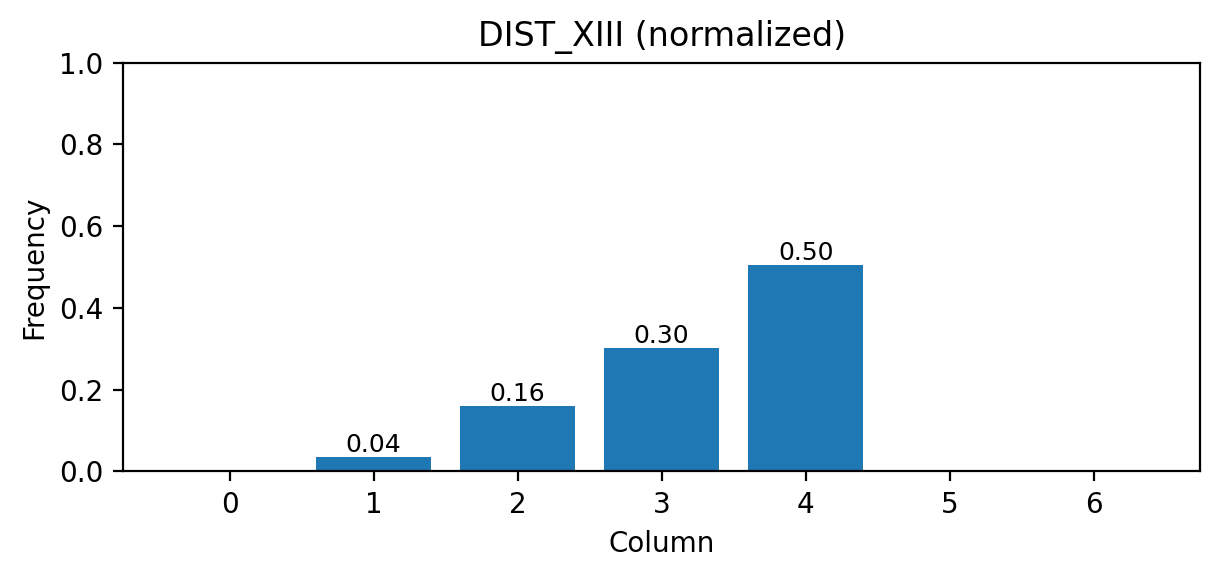

In [10]:
eh = plot_exploitation_histogram(counts, model_name)
plt.show(eh)

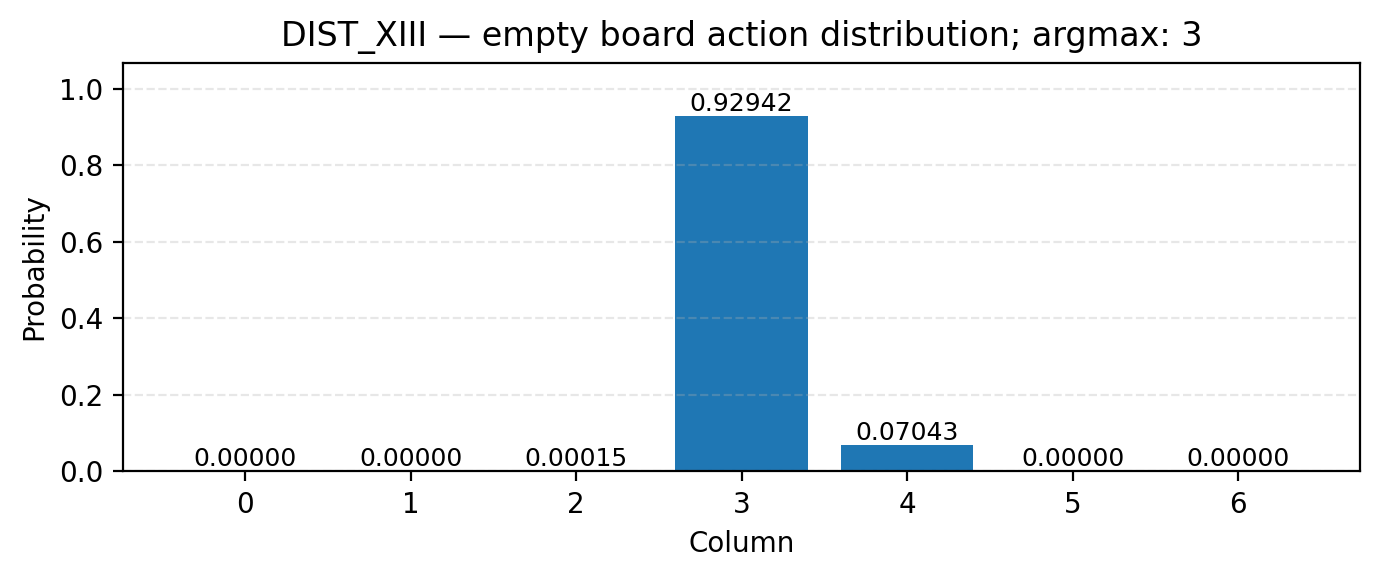

In [11]:
eba = plot_empty_board_action_distribution(policy, model_name)
plt.show(eba)

# Evaluation

In [12]:
EXCEL_OUT = "EVAL_PPO_results.xlsx"
t0 = time.time()
evaluation_results = evaluate_actor_critic_model(policy, EVALUATION_OPPONENTS, seed=SEED)
elapsed_h = (time.time() - t0) / 3600.0
row = results_to_row(run_tag=TRAINING_SESSION, results=evaluation_results, elapsed_h=elapsed_h, episodes=meta.get("episode"))
display(row)
append_eval_row_to_excel(row, EXCEL_OUT)
print("Saved to:", EXCEL_OUT)

Opponent: Random:   0%|          | 0/200 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-5:   0%|          | 0/50 [00:00<?, ?it/s]

,TIME [h],EPISODES,Random,Lookahead-1,Lookahead-2,Lookahead-3,Lookahead-4,Lookahead-5
TRAINING_SESSION,,,,,,,,
DIST_XIII,0.002621,None,0.715,0.0,0.0,0.0,0.0,0.0


Saved to: EVAL_PPO_results.xlsx


C:\Users\Uporabnik\Documents\JS\Connect4\Code\Jupiter\Connect4\PPO\ppo_agent_eval.py:238: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new = pd.concat([old, df_row.reset_index()], ignore_index=True)



📊 Evaluation Summary:
Random: 143W / 57L / 0D → Win: 71.5%, Loss: 28.5%, Draw: 0.0%
Lookahead-1: 0W / 100L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-2: 0W / 100L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-3: 0W / 100L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-4: 0W / 100L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-5: 0W / 50L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
📊 Plot saved to Plots/DQN/DQN-DIST_XIII-evaluation_plot.png


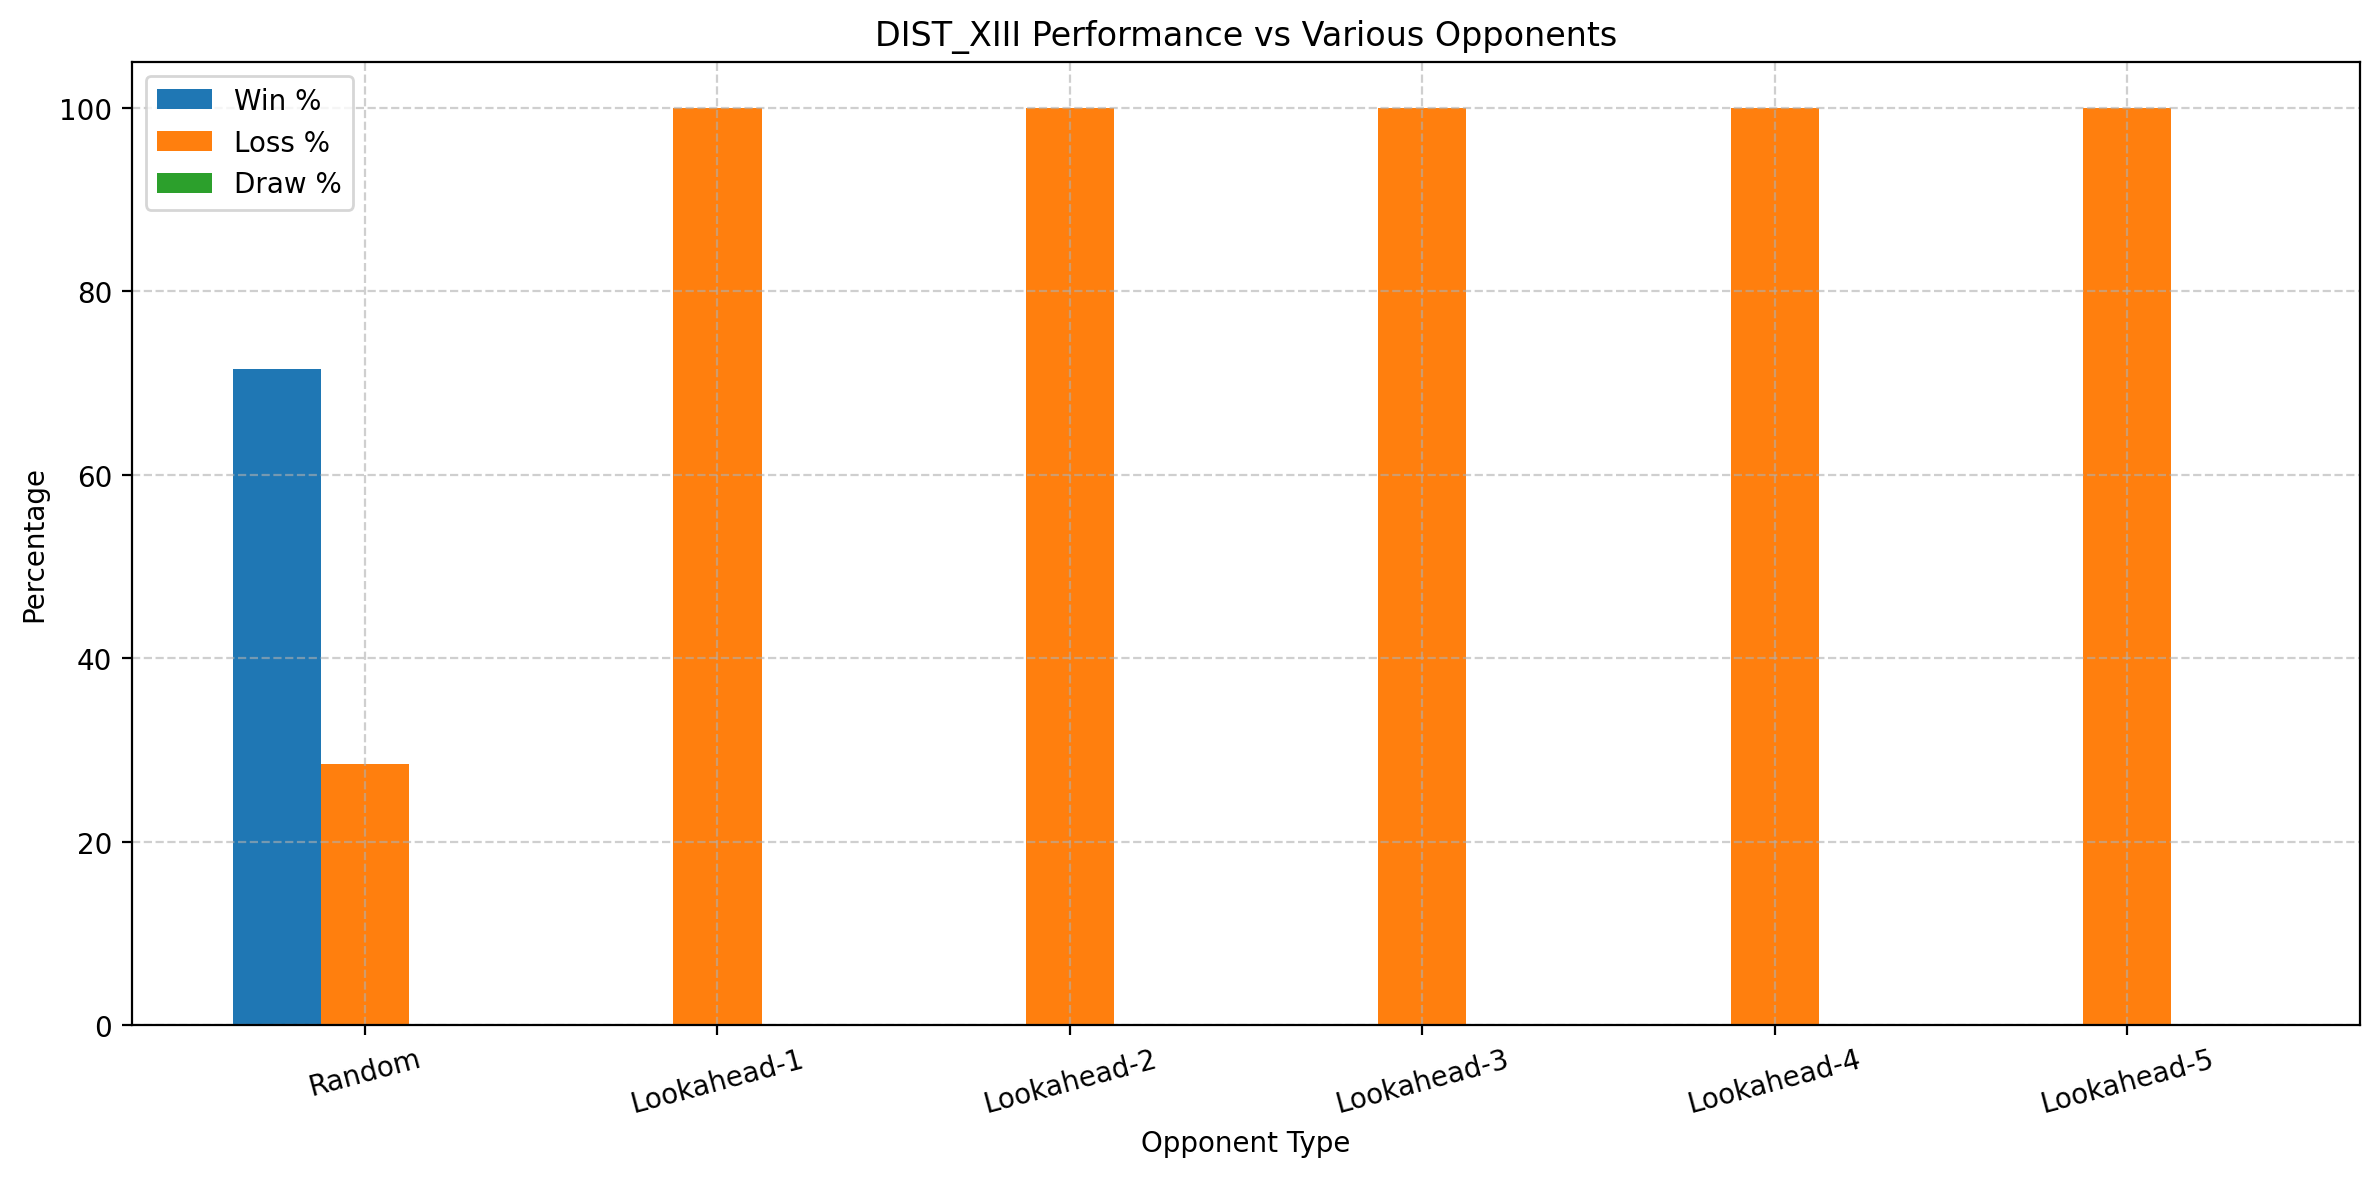

In [13]:
# === Print Summary ===
print("\n📊 Evaluation Summary:")
for label, stats in evaluation_results.items():
    print(f"{label}: {stats['wins']}W / {stats['losses']}L / {stats['draws']}D → "
          f"Win: {stats['win_rate']*100:.1f}%, Loss: {stats['loss_rate']*100:.1f}%, Draw: {stats['draw_rate']*100:.1f}%")

# === Bar Plot Summary ===
labels = list(evaluation_results.keys())
win_rates  = [evaluation_results[k]['win_rate']  * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %')
plt.bar([i + bar_width for i in x], loss_rates, width=bar_width, label='Loss %')
plt.bar([i + 2 * bar_width for i in x], draw_rates, width=bar_width, label='Draw %')
plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title(f'{model_name} Performance vs Various Opponents')
plt.xticks([i + bar_width for i in x], labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plot_path = f"{PLOTS}DQN-{TRAINING_SESSION}-evaluation_plot.png"
plt.savefig(plot_path, dpi=150)
print(f"📊 Plot saved to {plot_path}")

plt.show()

### Boards


🎯 Opponent: Random


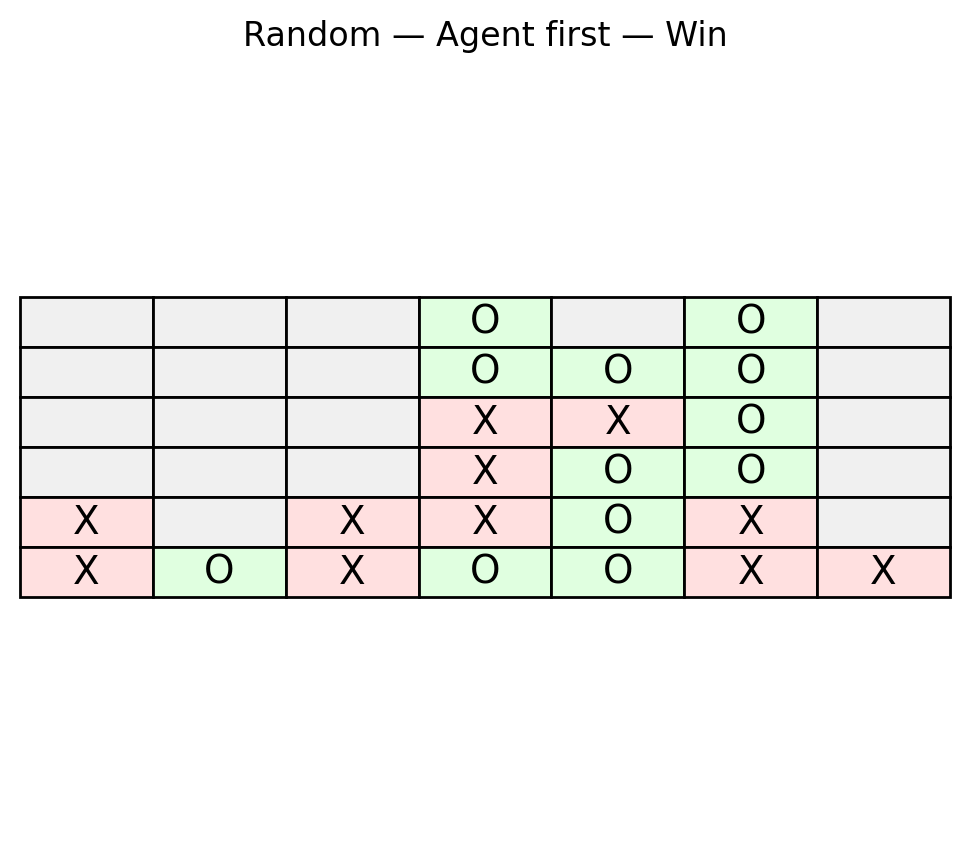

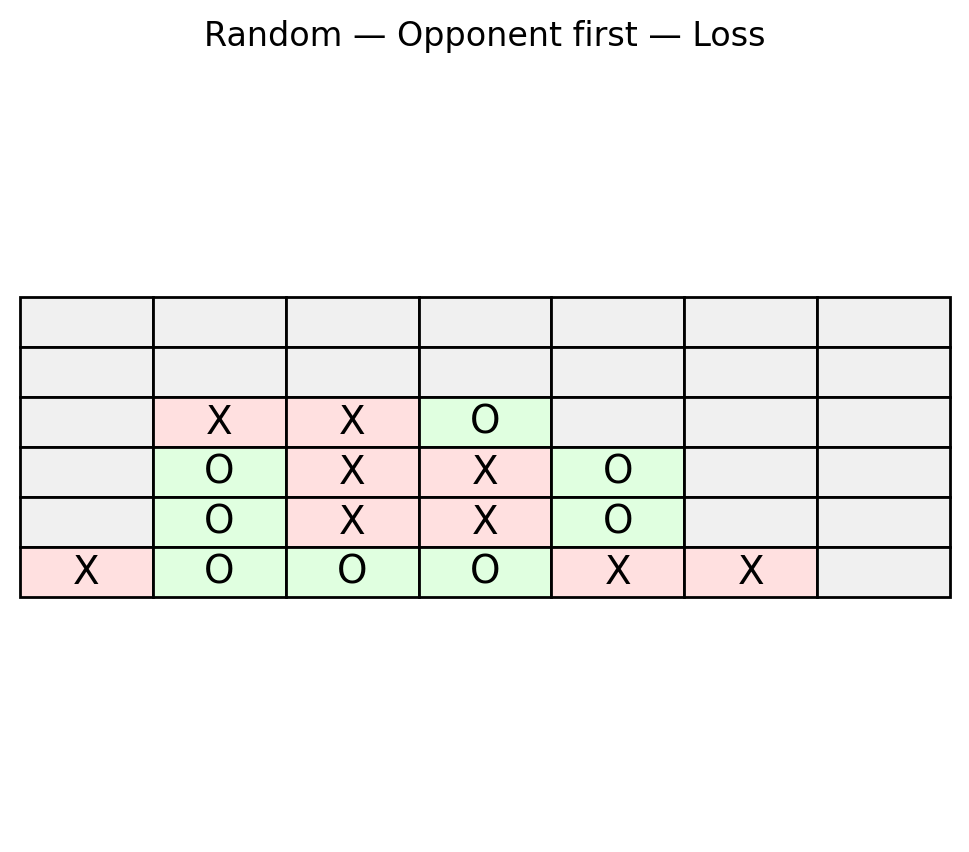

In [14]:
display_final_boards_PPO(policy, ["Random"])


🎯 Opponent: Lookahead-1


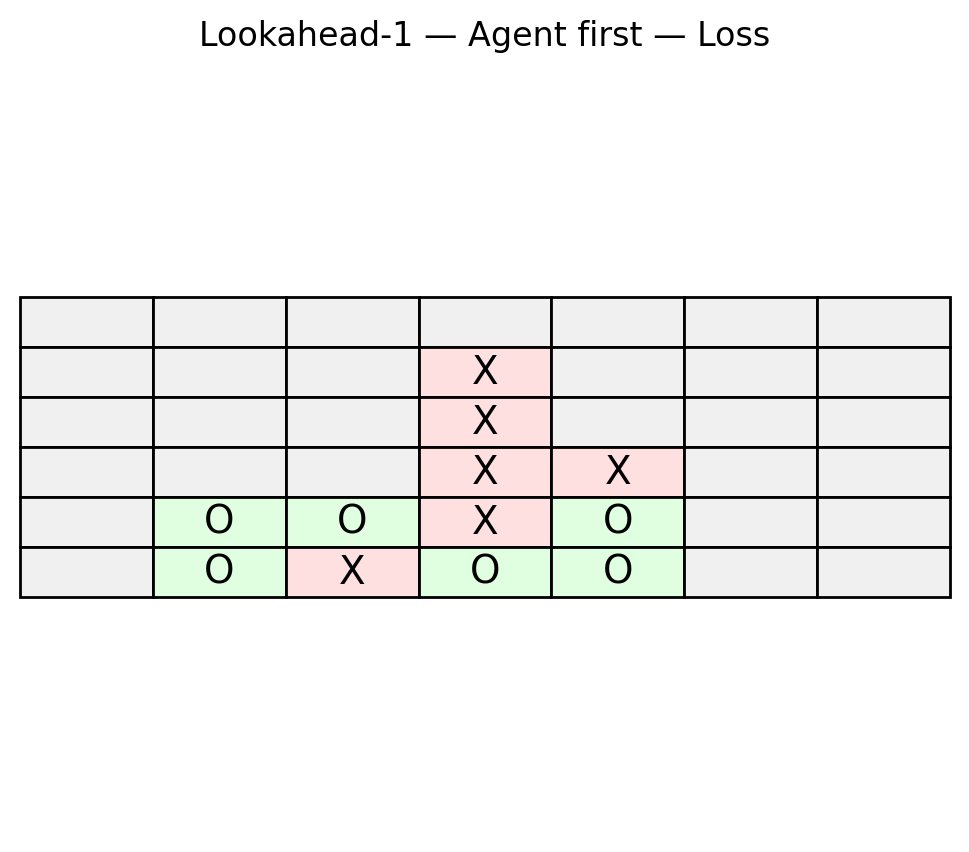

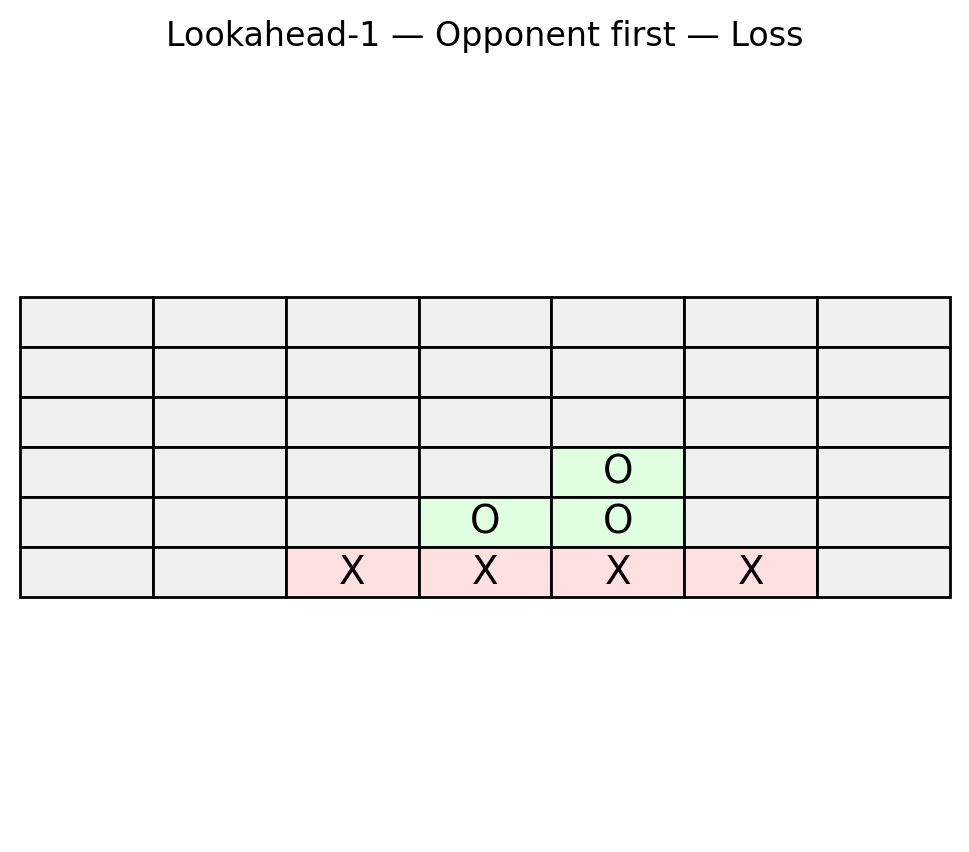

In [15]:
display_final_boards_PPO(policy, ["Lookahead-1"])


🎯 Opponent: Lookahead-2


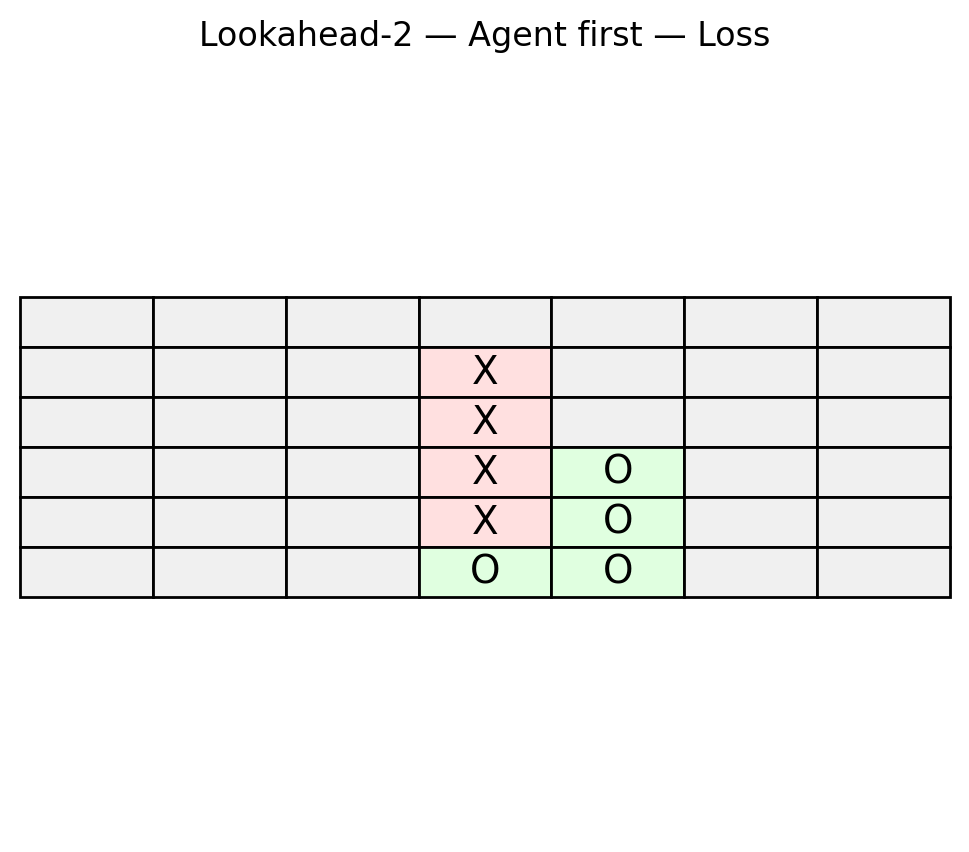

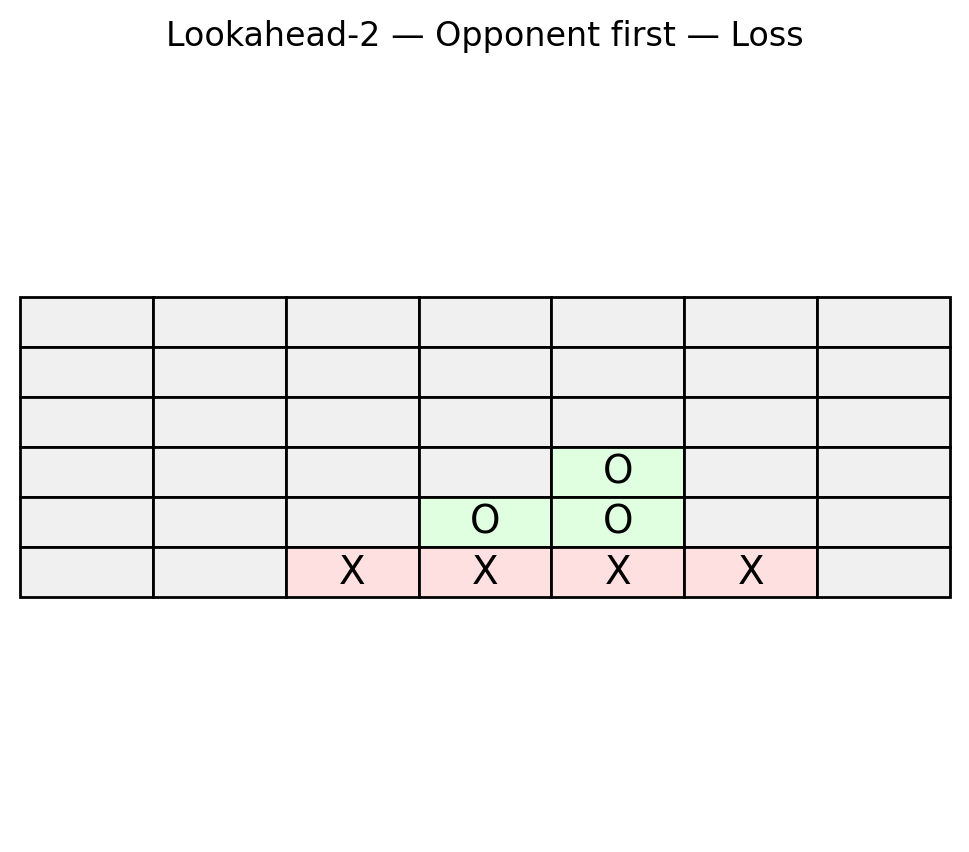

In [16]:
display_final_boards_PPO(policy, ["Lookahead-2"])


🎯 Opponent: Lookahead-3


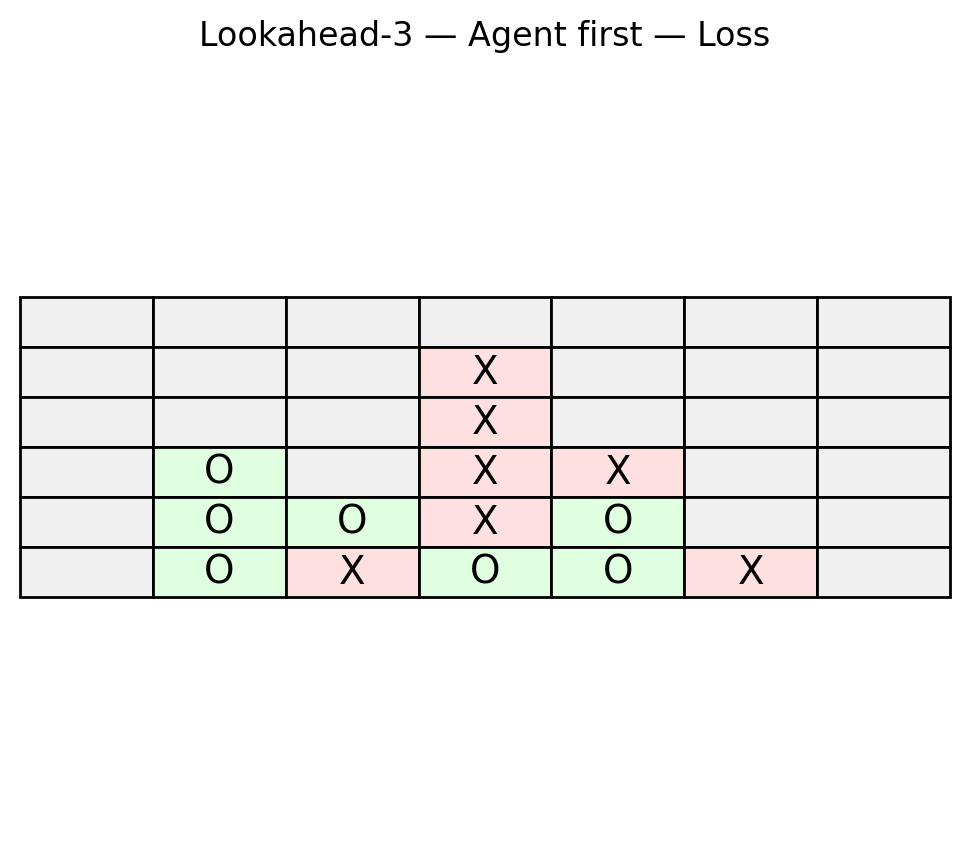

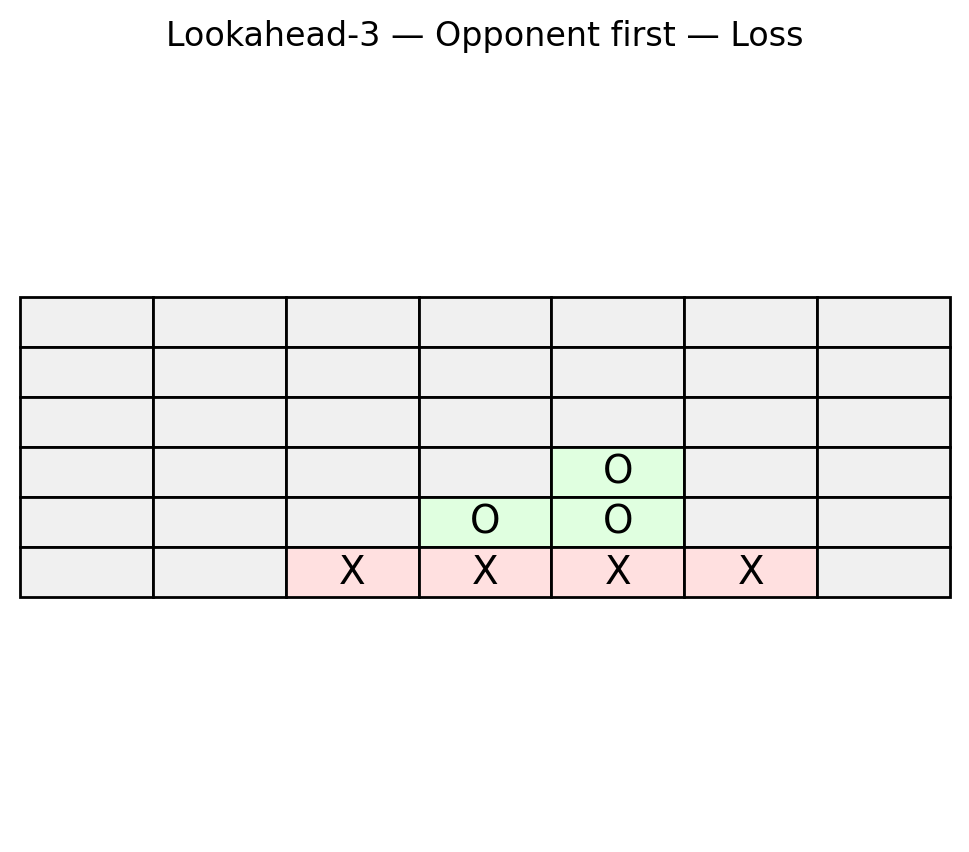

In [17]:
display_final_boards_PPO(policy, ["Lookahead-3"])


🎯 Opponent: Lookahead-4


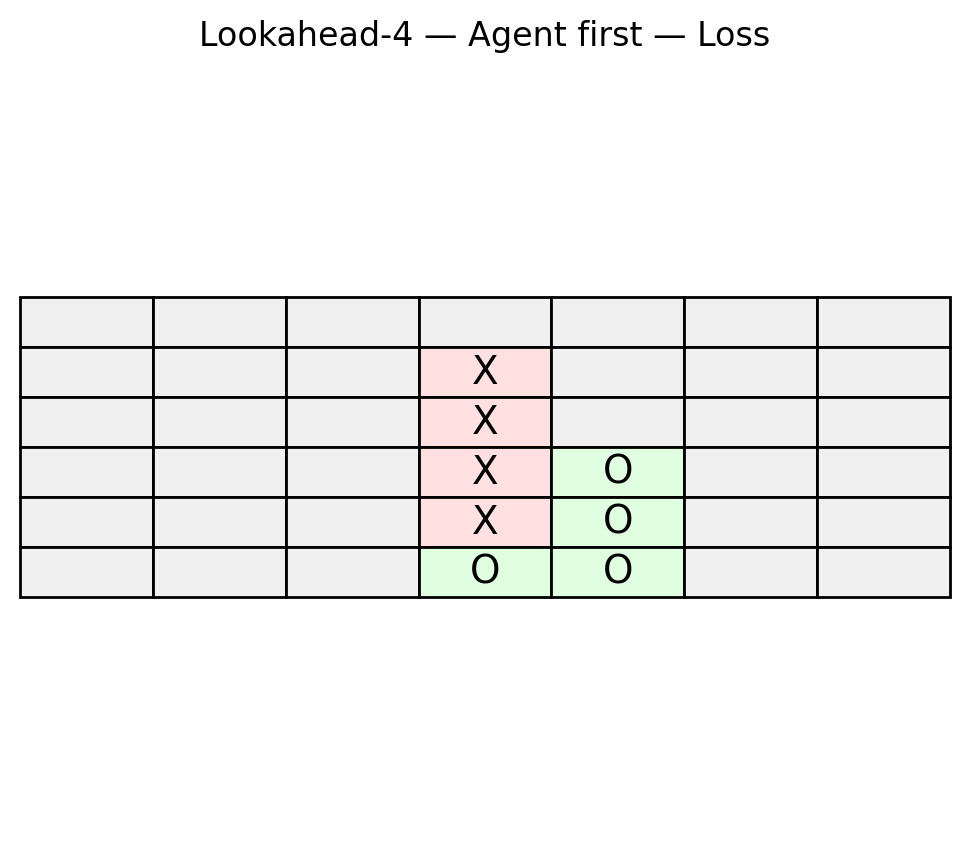

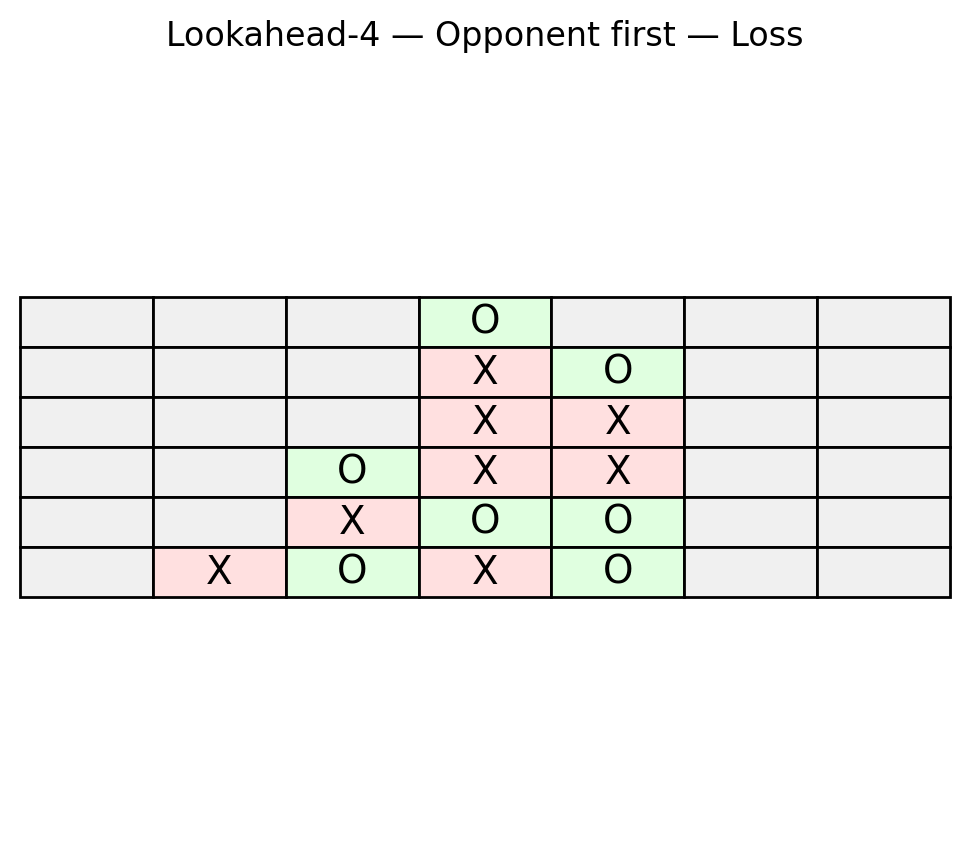

In [18]:
display_final_boards_PPO(policy, ["Lookahead-4"])


🎯 Opponent: Lookahead-5


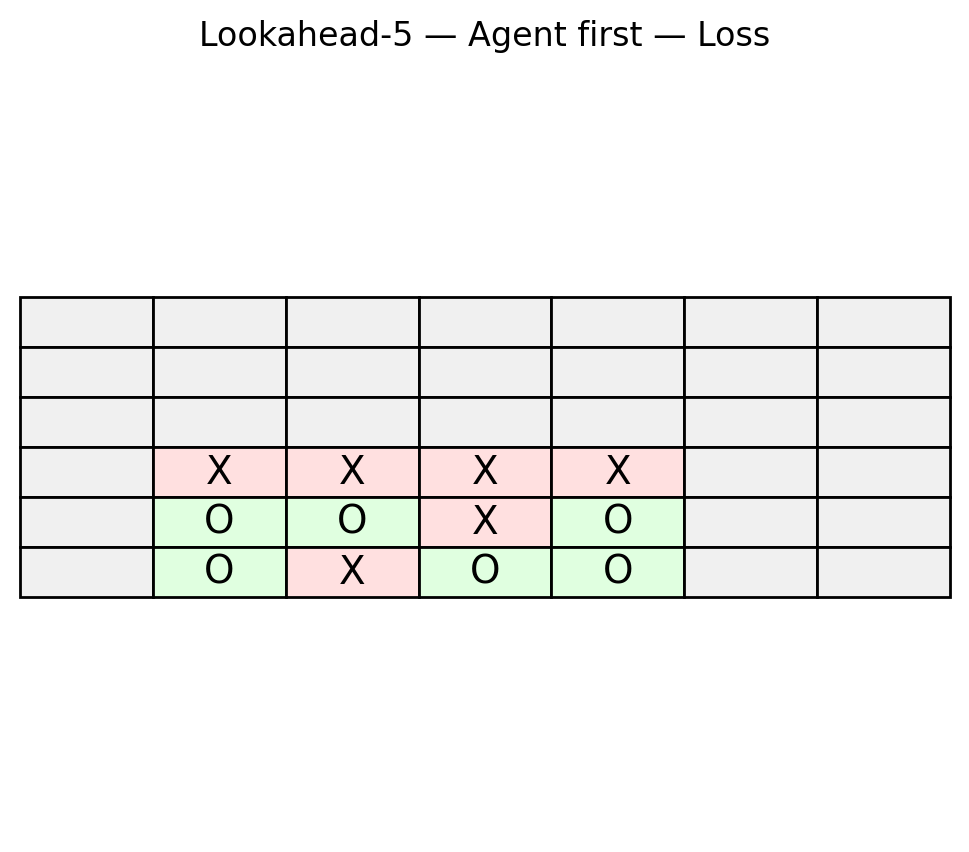

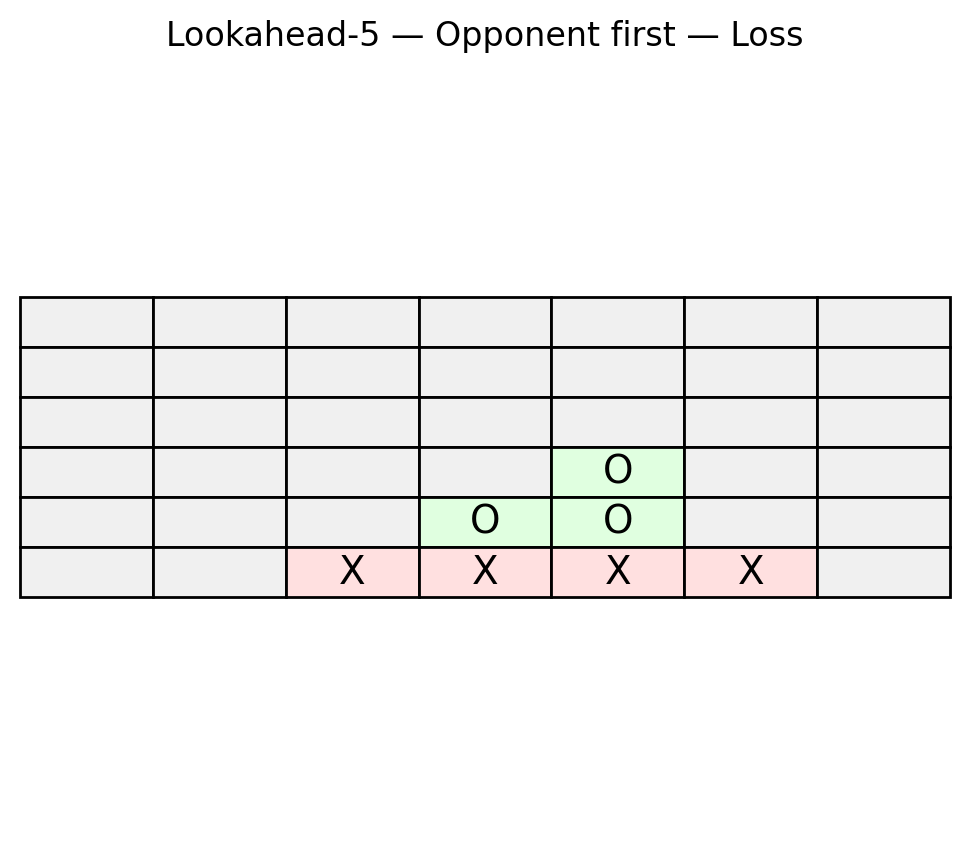

In [19]:
display_final_boards_PPO(policy, ["Lookahead-5"])

# DONE

In [20]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 0.0 hours
